## Final Project Submission

Please fill out:
* Student name: Charlotte Basch
* Student pace: self paced / part time / <strong>full time</strong>
* Scheduled project review date/time: 11/4/2020, 2pm
* Instructor name: James Irving
* Blog post URL: https://charsarb.github.io/trying_to_make_a_neural_network_stable

# Introduction

&nbsp; &nbsp; &nbsp; As of April 30, 2020, Twitter <a href="https://s22.q4cdn.com/826641620/files/doc_financials/2020/q1/Q1-2020-Earnings-Press-Release.pdf" target="_blank">reported</a> 166 million daily users. In the United States, this includes <a href="https://www.pewresearch.org/fact-tank/2019/04/10/share-of-u-s-adults-using-social-media-including-facebook-is-mostly-unchanged-since-2018/" target="_blank">22% of adults</a>, who are in general young and relatively affluent. This makes Twitter an excellent resource for gauging consumer sentiment. That is the aim of this project. Using <a href="https://data.world/crowdflower/brands-and-product-emotions" target="_blank">data</a> from CrowdFlower, tweets about Apple and Google products were analyzed to be able to predict positive and negative sentiment. This dataset consists of 9,000 tweets labeled by individuals as positive, negative, neither, or marked as unknown. However only the positive and negative tweets were considered in the model. 

&nbsp; &nbsp; &nbsp; The data were analyzed by both simpler models and multiple Long Short Term Memory networks with different parameters. While none of the models performed ideally, the best neural network model used a tokenizer created embedding layer, one LSTM layer with a tanh activation function and l2 regularization. However our best overall model was a logistic regression classifier. This model was 82% accurate. In addition, this model was quicker to run, required fewer resources, and produced more consistent results. This shows that a more complex model is not always better.  

# Data Cleaning and Exploration

## Importing Necessary Packages

In [1]:
import numpy as np
import tensorflow as tf
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt 
%matplotlib inline
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from nltk import word_tokenize
import preprocessor as p
import sklearn.metrics as metrics
from gensim.utils import simple_preprocess
from tensorflow.keras import regularizers, optimizers, layers, initializers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from wordcloud import WordCloud, STOPWORDS
import string
from nltk import FreqDist, word_tokenize, BigramCollocationFinder
import re
from nltk.collocations import BigramAssocMeasures
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
pd.set_option("display.max_rows", 500, "display.max_columns", None)

First we must import and preview the data. The column names are very cumbersome so for the sake of conciseness, we will rename them more simply. 

In [3]:
data = pd.read_csv("tweet_product_company.csv", encoding = "unicode_escape")
data = data.rename(columns={"emotion_in_tweet_is_directed_at": "product", 
                            "is_there_an_emotion_directed_at_a_brand_or_product": "emotion"})
data.head()

,tweet_text,product,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


We are not interested in the specific product at this time, just the tweet and the emotion it so we only look at these columns. We are also only interested in predicting positive or negative sentiment so we can eliminate the 'no emotion' and 'I can't tell' rows. This leaves us with an quite imbalanced dataset, with approximately 5 times more positive than negative tweets. 

In [4]:
data["emotion"].value_counts(normalize=True, dropna=False)

No emotion toward brand or product    0.592654
Positive emotion                      0.327505
Negative emotion                      0.062686
I can't tell                          0.017156
Name: emotion, dtype: float64

In [5]:
data = data[data["emotion"] != "I can't tell"]
data = data.loc[(data["emotion"] != "I can't tell") & (data["emotion"] != "No emotion toward brand or product")]
data["emotion"].value_counts(normalize=True, dropna=False)

Positive emotion    0.839346
Negative emotion    0.160654
Name: emotion, dtype: float64

In [6]:
#Finish cleaning the outcome variable by making it numerical
data["emotion"] = data["emotion"].replace({"Negative emotion": 0, 
                                           "Positive emotion": 1})

## Preprocess the Text

In [7]:
#Make a copy of the data to clean and get rid of the product column
data_cleaned = data.copy()
data_cleaned = data_cleaned.drop(columns=["product"])

In order to prepare the tweets for modeling we must get rid of the irrelevant information including emojis, urls, and mentions. In addition there are some html character entity references such as using 'quot' preceded by an ampersand and followed by a semicolon that are not words and can therefore be removed. We replace these with their proper symbols.

In [8]:
from gensim.utils import decode_htmlentities
cleaned_tweets = []
for row in data["tweet_text"].index:
    cleaned_tweets.append(decode_htmlentities(p.clean(data["tweet_text"][row])))
    
#Create a new dataframe for our cleaned tweets
data_cleaned["tweet_text"] = cleaned_tweets

In [9]:
data_cleaned.head()

,tweet_text,emotion
0,". I have a G iPhone. After hrs tweeting at , i...",0
1,Know about ? Awesome iPad/iPhone app that you'...,1
2,Can not wait for also. They should sale them d...,1
3,I hope this year's festival isn't as crashy as...,0
4,"great stuff on Fri : Marissa Mayer (Google), T...",1


In [10]:
#Seperate the positive and negative tweets so we can examine them more closely
pos_tweets = data_cleaned[data_cleaned["emotion"] == 1]["tweet_text"].values
neg_tweets = data_cleaned[data_cleaned["emotion"] == 0]["tweet_text"].values

When trying to find the most common words, it does not serve us to have less meaningful words like 'the' because it is likely both positive and negative tweets will contain this word. Therefore we can use a pre-existing list of common words and add the abbreviation for retweeting to make sure they are not part of our examinations. We can also add the indication of whether or not there is a link because that does not give us information about the content of the link. "Via" is also used to indicate the link is the source of the information so that can be eliminated as well. In addition many of these tweets are from South by Southwest so Austin and SXSW will appear frequently without telling us much. Therefore we can eliminate these words too. Lastly, we can eliminate product and brand names as they will be common in both positive and negative tweets. 

In [11]:
#Get the common words and add RT, products, and link
stopwords = list(STOPWORDS)
stopwords.extend(["rt", "link", "austin", "sxsw", "iphone", "ipad", "apple", "android", "google",
                  "ipad2", "via"])

## Visualizations

We can get a more holistic view of the dataset for each emotion by making wordclouds, where the most common words are represented more largely and then examine the top 25 words for each emotion in more depth. 

In [12]:
#from https://www.geeksforgeeks.org/generating-word-cloud-python/
def make_wordcloud(tweets, title):
    """Create a wordcloud based on a list of tweets."""
    
    cloud_words = " "
    for tweet in tweets: 
        #Get rid of punctuation
        tweet = re.sub(r"[^\w\s]", "", tweet)
        words = tweet.split()
        for i in range(len(words)): 
            words[i] = words[i].lower()  
        cloud_words += " ".join(words)+" "
    wordcloud = WordCloud(stopwords=stopwords, colormap="YlGnBu").generate(cloud_words) 
    plt.figure(figsize = (8, 8)) 
    plt.title(f"Wordcloud for {title}")
    plt.imshow(wordcloud) 
    plt.axis("off")
    
def get_most_frequent_words(tweets, num_words_freq=25, num_words_pairs=15):
    """Find the most common words of a dataset."""
    
    words_to_count = []
    for tweet in tweets:
        #Get rid of punctuation 
        tweet = re.sub(r"[^\w\s]", "", tweet)
        words = tweet.split()
        for word in words:
            #check if the word is one of our common words that we wish to exclude
            if word.lower() not in stopwords:
                words_to_count.append(word.lower())
    #tokenize the words            
    tokens = word_tokenize(" ".join(words_to_count))
    #find the frequency of each word
    freq  = FreqDist(tokens)
    #Single out the top words
    most_freq = freq.most_common(num_words_freq)
    #find the most common pairs of words
    bigram_measures = BigramAssocMeasures()
    tweet_finder = BigramCollocationFinder.from_words(tokens)
    tweet_finder.apply_freq_filter(5)
    tweets_scored = tweet_finder.score_ngrams(bigram_measures.pmi)
    most_freq_pairs = tweets_scored[:num_words_pairs]
    return most_freq, most_freq_pairs

### Wordclouds

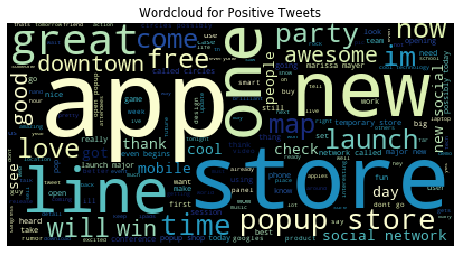

In [13]:
#Get the wordcloud for the positive tweets
make_wordcloud(pos_tweets, "Positive Tweets")

It makes sense that words like great and awesome are prominent enough to read in the positive tweets. In addition, words related to novelty and purchase appear common.

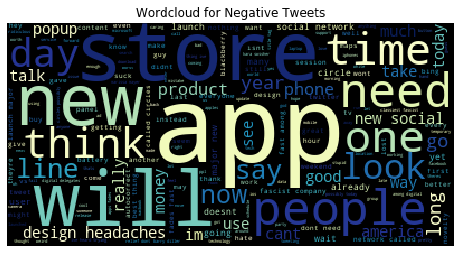

In [14]:
#Get the wordcloud for the negative tweets
make_wordcloud(neg_tweets, "Negative Tweets")

There are also a lot of words related to purchase and novelty. The modal verbs also appear more common in the negative tweets.  

### Most Frequent Words

- We can now look more specifically at the most common words for each type of tweet. 

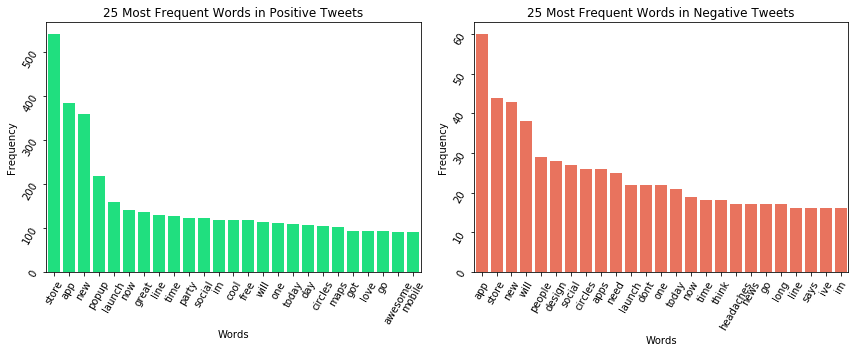

In [15]:
#Get the most frequent words for each emotion
pos_most_freq, pos_most_freq_pairs = get_most_frequent_words(pos_tweets)
neg_most_freq, neg_most_freq_pairs = get_most_frequent_words(neg_tweets)

#Seperate the words and their counts
pos_words = []
neg_words = []
pos_counts = []
neg_counts = []
for i in range(len(pos_most_freq)):
    pos_words.append(pos_most_freq[i][0])
    pos_counts.append(pos_most_freq[i][1])
    neg_words.append(neg_most_freq[i][0])
    neg_counts.append(neg_most_freq[i][1])
    
#Graph the words and their frequencies
fig, axes = plt.subplots(ncols=2, figsize=(12, 5));
sns.barplot(x=pos_words, y=pos_counts, ax=axes[0], color="springgreen")
axes[0].set(title="25 Most Frequent Words in Positive Tweets", ylabel="Frequency", xlabel="Words")
sns.barplot(x=neg_words, y=neg_counts, ax=axes[1], color="tomato") 
axes[1].set(title="25 Most Frequent Words in Negative Tweets", ylabel="Frequency", xlabel="Words")
for ax in fig.axes:
    ax.tick_params(labelrotation=60)
plt.tight_layout()

- While great, awesome, and love are in the top 25 positive words, headaches is more prominent in the negative words. 
- Many of the positive words seems to indicate being exposed to new content (i.e. 'popup'). While some of those words appear in the negative tweets, they appear less frequently. 
- Interestingly, need only appears as a top word for negative tweets. In addition will appears more frequently in negative rather than positive tweets. 

### Most Related Pairs 

- While the most common words give some insight, we can also look at what words appear together and their degree of relatedness for each type of tweet. 

In [16]:
#We can put the most related words and their pointwise mutual information scores into a dataframe to 
#make reading easier.
pd.DataFrame(pos_most_freq_pairs, columns=["Pairs", "PMI"])

,Pairs,PMI
0,"(alternate, routes)",12.171052
1,"(ice, cream)",12.171052
2,"(interrupt, regularly)",12.171052
3,"(league, extraordinary)",11.908017
4,"(lustre, pearl)",11.908017
5,"(speech, therapy)",11.908017
6,"(exhibit, hall)",11.685625
7,"(regularly, scheduled)",11.685625
8,"(awesomely, rad)",11.171052
9,"(haha, awesomely)",11.171052


In [17]:
pd.DataFrame(neg_most_freq_pairs, columns=["Pairs", "PMI"])

,Pairs,PMI
0,"(title, tag)",9.628446
1,"(kara, swisher)",9.213408
2,"(barry, diller)",9.143019
3,"(marissa, mayer)",8.891480
4,"(among, digital)",8.850838
5,"(digital, delegates)",8.850838
6,"(fast, among)",8.628446
7,"(way, caring)",8.512968
8,"(fades, fast)",8.476442
9,"(money, relief)",8.406053


- These bigrams imply that perhaps feelings about SXSW, the event occurring when many of the tweets were sent, is being captured rather than sentiment about the products.
- None of the related words seem to provide insight about sentiment. 

# Tweet Classification

In [18]:
#We split the data into X and y and then split the data into testing and training datasets
X = data_cleaned["tweet_text"]
y = data_cleaned["emotion"].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.2)

In [19]:
#We must now split the words into tokens so they can be fed into our models
vectorizer = TfidfVectorizer()
X_train_tf_idf = vectorizer.fit_transform(X_train)
X_test_tf_idf = vectorizer.transform(X_test)

In [20]:
def evaluate_classifier(X_train, y_train, X_test, y_test, model, labels):
    """Get the classification report and confusion matrix for a provided model."""
    
    #Predict values for the test set
    y_hat_test = model.predict(X_test)
    
    #Label and print the classification report
    model_name = str(model).split("(")[0]
    print(f"Classification Report for {model_name} \n") 
    print(metrics.classification_report(y_test, y_hat_test, target_names=labels))
    
    metrics.plot_confusion_matrix(model, X_test, y_test, normalize="true", 
                                  display_labels=labels, cmap="YlGnBu")
    plt.title("Confusion Matrix", y=1.05)

## Naive Bayes

- One of the most common, simple, and effective means of text classification is applying a naive Bayes classifier.

Classification Report for MultinomialNB 

              precision    recall  f1-score   support

    Negative       1.00      0.04      0.08       115
    Positive       0.84      1.00      0.92       595

    accuracy                           0.85       710
   macro avg       0.92      0.52      0.50       710
weighted avg       0.87      0.85      0.78       710



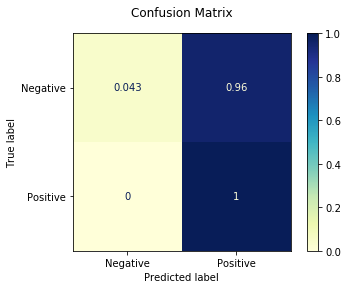

In [21]:
bayes = MultinomialNB()
bayes.fit(X_train_tf_idf, y_train)
evaluate_classifier(X_train_tf_idf, y_train, X_test_tf_idf, y_test, bayes, ["Negative", "Positive"])

- Clearly this model mostly predicts the most common class. Therefore we can move to a more complex model. 

## Logistic Regression

- Next we move to logistic regression. We know we will need to address the relative prominence of positive tweets in our dataset so we start by using balanced class weights.

Classification Report for LogisticRegression 

              precision    recall  f1-score   support

    Negative       0.37      0.70      0.49       115
    Positive       0.93      0.77      0.85       595

    accuracy                           0.76       710
   macro avg       0.65      0.74      0.67       710
weighted avg       0.84      0.76      0.79       710



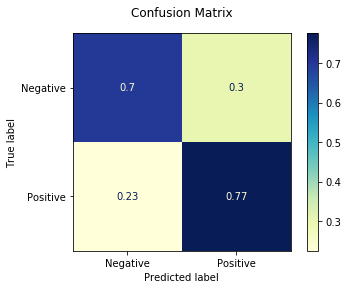

In [22]:
logreg = LogisticRegression(C=.1, random_state=42, class_weight="balanced", solver="liblinear")
logreg.fit(X_train_tf_idf, y_train)
evaluate_classifier(X_train_tf_idf, y_train, X_test_tf_idf, y_test, logreg, ["Negative", "Positive"])

- This model already performs better than random chance at classifying tweets as positive or negative. We can attempt to improve it by trying out different parameters for regularization strength and class balance.
- Because our data is imbalanced, we seek to maximize the balanced accuracy.
- Multiple grid searches were run utilizing different weight ratios. 
- We began with smaller ratios to reflect the proportion of negative to positive tweets. However this still resulted in over-predicting positives. Thus the ratio was made more and more extreme. 
- The following grid search was run to produce the model below:

` param_grid = {"C": [.01, .1, 1, 10, 100, 1000],
              "class_weight": ["balanced", {0:10, 1:1}, {0:100, 1:1}, {0:1000, 1:1}, {0:10000, 1:1},
                              {0:5000, 1:1}, {0:3000, 1:1}, {0:7000, 1:1}]}
gridsearch_lr = GridSearchCV(logreg, param_grid=param_grid, cv=5, scoring="balanced_accuracy")
gridsearch_lr.fit(X_train_tf_idf, y_train)
gridsearch_lr.best_params_ `

Classification Report for LogisticRegression 

              precision    recall  f1-score   support

    Negative       0.41      0.80      0.54       115
    Positive       0.95      0.77      0.85       595

    accuracy                           0.78       710
   macro avg       0.68      0.79      0.70       710
weighted avg       0.86      0.78      0.80       710



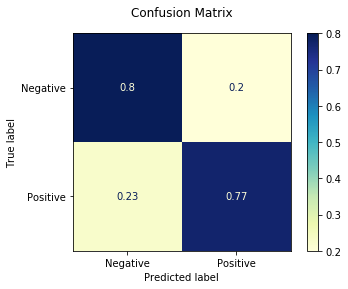

In [23]:
gs_logreg = LogisticRegression(C=10, random_state=42, class_weight={0: 1000, 1: 1}, solver="liblinear")
gs_logreg.fit(X_train_tf_idf, y_train)
evaluate_classifier(X_train_tf_idf, y_train, X_test_tf_idf, y_test, gs_logreg, ["Negative", "Positive"])

- This model improves on the accuracy and most other metrics compared to the initial model. 
- However the results of the grid search were initially misread and incorrect parameters were reserved. 
- When this model was run, it became clear that this model was 4% more accurate than the model identified by the grid search and had higher f1 scores. Therefore we decided to use the accidentally discovered model.

Classification Report for LogisticRegression 

              precision    recall  f1-score   support

    Negative       0.46      0.75      0.57       115
    Positive       0.94      0.83      0.89       595

    accuracy                           0.82       710
   macro avg       0.70      0.79      0.73       710
weighted avg       0.87      0.82      0.84       710



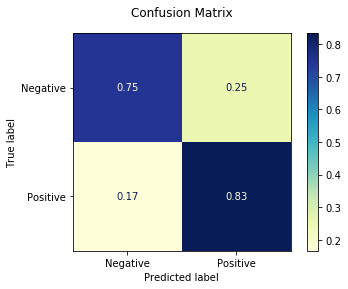

In [24]:
best_logreg = LogisticRegression(C=100, random_state=42, class_weight={0:7000, 1:1}, solver="liblinear")
best_logreg.fit(X_train_tf_idf, y_train)
evaluate_classifier(X_train_tf_idf, y_train, X_test_tf_idf, y_test, best_logreg, ["Negative", "Positive"])

- While the model might be sufficient, we can see if using a more complex classifier produces better results.

## Random Forest

- Once again we can start by trying to balance the classes. 

Classification Report for RandomForestClassifier 

              precision    recall  f1-score   support

    Negative       0.91      0.28      0.43       115
    Positive       0.88      0.99      0.93       595

    accuracy                           0.88       710
   macro avg       0.90      0.64      0.68       710
weighted avg       0.88      0.88      0.85       710



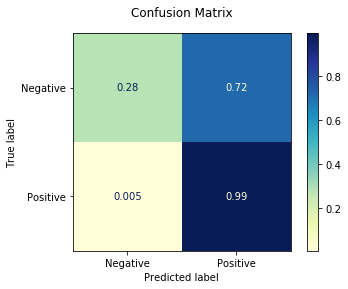

In [25]:
random_forest = RandomForestClassifier(random_state=42, class_weight="balanced")
random_forest.fit(X_train_tf_idf, y_train)
evaluate_classifier(X_train_tf_idf, y_train, X_test_tf_idf, y_test, random_forest, ["Negative", "Positive"])

- Clearly this model is mostly predicting the majority class so we can again try to search for more ideal parameters. 

- The following search was run and produced the optimal parameters used below:

` param_grid = {"criterion": ["gini", "entropy"],
              "min_samples_split": [5, 10, 15, 20],
              "min_samples_leaf": [1, 5, 10, 20],
              "class_weight": ["balanced", {0:10, 1:1}, {0:100, 1:1}, {0:1000, 1:1}, {0:10000, 1:1},
                              {0:5000, 1:1}, {0:3000, 1:1}, {0:7000, 1:1}]}
gridsearch = GridSearchCV(random_forest, param_grid=param_grid, cv=5, scoring="balanced_accuracy")
gridsearch.fit(X_train_tf_idf, y_train)
gridsearch.best_params_ `

Classification Report for RandomForestClassifier 

              precision    recall  f1-score   support

    Negative       0.35      0.83      0.49       115
    Positive       0.96      0.70      0.81       595

    accuracy                           0.72       710
   macro avg       0.65      0.77      0.65       710
weighted avg       0.86      0.72      0.75       710



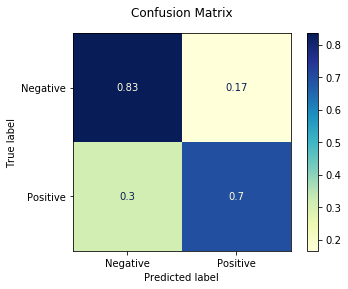

In [26]:
best_rf = RandomForestClassifier(random_state=42, class_weight={0: 10, 1: 1}, criterion="entropy", 
                                 min_samples_leaf=5, min_samples_split=5)
best_rf.fit(X_train_tf_idf, y_train)
evaluate_classifier(X_train_tf_idf, y_train, X_test_tf_idf, y_test, best_rf, ["Negative", "Positive"])

- Overall our logistic regression model is more accurate so for now that is our best model. 
- However we can also investigate neural networks as a means for providing more insight into the tweet classification task.

# Neural Networks

## Embedding

First we begin building our own embedding layer. While not shown, initially the GloVe vector pre-trained on twitter data was used, but it was missing certain important product words that are relevant to this problem. Therefore we create the vector ourselves.  

In [27]:
#We get the lowercase of each word, remove punctuation, etc. and seperate each word
tweets = data_cleaned["tweet_text"].map(lambda x: simple_preprocess(x,True))

#preview the further cleaned tweets
tweets[:5]

0    [have, iphone, after, hrs, tweeting, at, it, w...
1    [know, about, awesome, ipad, iphone, app, that...
2    [can, not, wait, for, also, they, should, sale...
3    [hope, this, year, festival, isn, as, crashy, ...
4    [great, stuff, on, fri, marissa, mayer, google...
Name: tweet_text, dtype: object

In [28]:
#Create and train the model
model = Word2Vec(tweets)

model.train(tweets, total_examples=model.corpus_count,epochs=10)

(310922, 524540)

In order to check how our model learned, we view the most similar words to iphone. For the most part, the similar words make quite a bit of sense. The model has correctly realized iphone and android are similar products. It also contains words people use when talking about their phones (i.e. 'check') and things related to smartphones (i.e. 'app'). Not every word makes sense, which is why we will compare this to an embedding layer made from our tokenizer. 

In [29]:
wv = model.wv

#save the number of words in the vocabularly that the model has learned
vocab_size = len(wv.vocab)

wv.most_similar("iphone")

[('android', 0.9510033130645752),
 ('my', 0.929986298084259),
 ('thanks', 0.9294365048408508),
 ('our', 0.9019006490707397),
 ('download', 0.8920776844024658),
 ('got', 0.8820561170578003),
 ('awards', 0.8808989524841309),
 ('check', 0.8748332858085632),
 ('or', 0.8658884763717651),
 ('market', 0.8583544492721558)]

In [30]:
#We must save the model so tthat later we can load in the model and use it to make an embedding layer 
filename = "word2vec_tweets.txt"
wv.save_word2vec_format(filename)

In [31]:
#Preview our fully cleaned data
data_cleaned.head()

,tweet_text,emotion
0,". I have a G iPhone. After hrs tweeting at , i...",0
1,Know about ? Awesome iPad/iPhone app that you'...,1
2,Can not wait for also. They should sale them d...,1
3,I hope this year's festival isn't as crashy as...,0
4,"great stuff on Fri : Marissa Mayer (Google), T...",1


## Splitting the Data

In [32]:
#Set our X and y variables and split them into training, validation, and testing sets
X = data["tweet_text"].copy()
y = data["emotion"].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42, test_size=.1)

- As discussed previously, the tweets in this dataset are mostly positive. This can create problems when modeling, where the most frequent class is predicted. 
- To address this, we will undersample the positive tweets in the training set.

In [33]:
#create a new dataframe for the training data
training_data = pd.concat([X_train, y_train], axis=1)

#Get the counts of each variable
pos_count, neg_count = training_data["emotion"].value_counts()

#Check that the training data looks as it should
training_data

,tweet_text,emotion
9017,Stopped by Tron Legacy Lounge at #SXSW. Audio...,1
7000,These iPhone apps will keep you grooving at #S...,1
4095,&quot;Apple likes it if you pay them. That's w...,0
3521,@mention How was Fri dinner and are you enjoyi...,1
1415,Nice Move: Apple set to open popup shop in cor...,1
...,...,...
731,@mention Its bigger than an iphone and smalle...,1
5963,RT @mention Having a hard time tweeting and us...,1
1038,Google is reproducing digitally the way you or...,1
8172,"ha, wow RT @mention Apple Opening Temporary iP...",1


In [34]:
#Sepearte the positive and negative tweets
pos_data = training_data[training_data["emotion"] == 1]
neg_data = training_data[training_data["emotion"] == 0]

#take a sample of positive tweets equal to the size of the negative tweets
pos_undersample = pos_data.sample(neg_count)
balanced_training = pd.concat([pos_undersample, neg_data], axis=0)

In [35]:
#check that there are the same number of tweets of each type and seperate the X and y data
print(balanced_training["emotion"].value_counts())
X_train = balanced_training["tweet_text"].copy()
y_train = balanced_training["emotion"].copy()

1    404
0    404
Name: emotion, dtype: int64


## Finishing Data Preparation

### Tokenizing

In order for the neural network to understand the text data we must tokenize it. 

In [36]:
tokenizer = Tokenizer(oov_token="OOV")
tokenizer.fit_on_texts(X_train)

#We want to preserve the order of the words so we keep them as sequences
X_train = tokenizer.texts_to_sequences(X_train)
X_val= tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)
y_train = y_train.values
y_test = y_test.values
y_val = y_val.values

#All of the sequences must be the same length so we add extra padding to all shorter than maximum sequences
X_train_padded = pad_sequences(X_train, maxlen=32)
X_test_padded = pad_sequences(X_test, maxlen=32)
X_val_padded = pad_sequences(X_val, maxlen=32)

#Save the word indices
word_index = tokenizer.word_index

Now we can load our word2vec model back in turn it into an embedding layer.

In [37]:
#from https://towardsdatascience.com/machine-learning-word-embedding-sentiment-classification-using-keras-b83c28087456
import os
embeddings_index = {}
f = open(os.path.join("", "word2vec_tweets.txt"), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_index[word] = coefs
f.close()
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, 100))
for word, i in word_index.items():
    if i > num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
embedding_layer = Embedding(num_words, 100, input_length=len(X_train_padded[0]),
                           embeddings_initializer=Constant(embedding_matrix),
                           trainable=False)

## Modeling

We do not want our network to keep going once there is no improvement so we set up a way to stop the model from learning after a certain time period of no improvement. In our case the network will stop learning if the loss of the validation set does not decrease by .01 for 5 epochs. This gives the network some time to learn at the beginning but still be prevented from going too far. In addition we will keep the best weights so that our model is performing optimally. 

In [38]:
earlystop = EarlyStopping(monitor="val_loss", min_delta = .01, patience=5, restore_best_weights=True)

In [39]:
def visualize_training_results(results):
    """Plot the loss and accuracy of both the training and validation sets."""
    
    history = results.history
    plt.figure()
    plt.plot(history["val_loss"])
    plt.plot(history["loss"])
    plt.legend(["Validation Loss", "Training Loss"])
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()
    
    plt.figure()
    plt.plot(history["val_accuracy"])
    plt.plot(history["accuracy"])
    plt.legend(["Validation Accuracy", "Training Accuracy"])
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.show()
    
def evaluate_model(model, X_test, y_test):
    """Create a classification report and confusion matrix for the model."""
    
    y_hat_test = model.predict(X_test).flatten().round()
    print(metrics.classification_report(y_test, y_hat_test, target_names=["Negative", "Positive"]))
    ax = sns.heatmap(metrics.confusion_matrix(y_test, y_hat_test, normalize="true"), cmap="YlGnBu", 
                annot=True, xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    ax.set(xlabel="True Label", ylabel="Predicted Label", title="Confusion Matrix")

While recommendations vary, a good amount of sources indicate that starting with relu as the activation function and adam as the optimizer is a good starting point.

Epoch 1/20
26/26 [==============================] - 2s 61ms/step - loss: 0.6809 - accuracy: 0.5693 - val_loss: 0.5511 - val_accuracy: 0.7817
Epoch 2/20
26/26 [==============================] - 1s 41ms/step - loss: 0.6615 - accuracy: 0.5978 - val_loss: 0.6392 - val_accuracy: 0.5704
Epoch 3/20
26/26 [==============================] - 1s 35ms/step - loss: 0.6630 - accuracy: 0.6423 - val_loss: 0.6824 - val_accuracy: 0.5528
Epoch 4/20
26/26 [==============================] - 1s 33ms/step - loss: 0.6455 - accuracy: 0.6411 - val_loss: 0.7565 - val_accuracy: 0.4577
Epoch 5/20
26/26 [==============================] - 1s 35ms/step - loss: 0.6217 - accuracy: 0.6473 - val_loss: 0.5223 - val_accuracy: 0.7254
Epoch 6/20
26/26 [==============================] - 1s 31ms/step - loss: 0.6218 - accuracy: 0.6460 - val_loss: 0.6731 - val_accuracy: 0.6021
Epoch 7/20
26/26 [==============================] - 1s 32ms/step - loss: 0.6096 - accuracy: 0.6510 - val_loss: 0.6471 - val_accuracy: 0.5951
Epoch 8/20
26

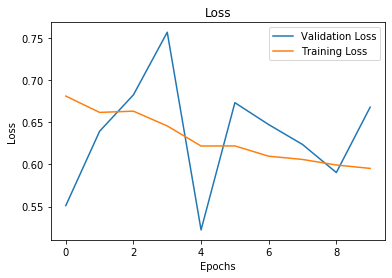

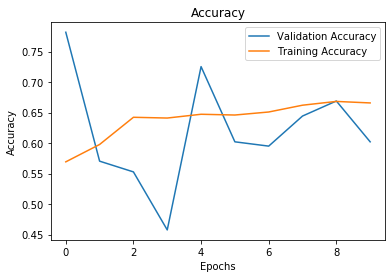

              precision    recall  f1-score   support

    Negative       0.30      0.42      0.35       115
    Positive       0.88      0.82      0.85       595

    accuracy                           0.75       710
   macro avg       0.59      0.62      0.60       710
weighted avg       0.79      0.75      0.77       710



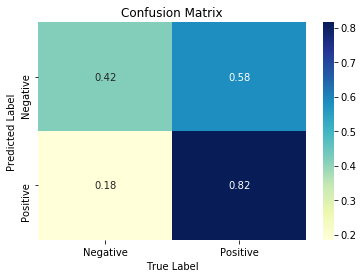

In [55]:
model1 = Sequential()
model1.add(embedding_layer)
model1.add(LSTM(units=100, activation="relu"))
model1.add(Dense(1, activation="sigmoid"))
model1.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
results1 = model1.fit(X_train_padded, y_train, validation_data=(X_val_padded,y_val), callbacks=[earlystop],
                   epochs=20)
visualize_training_results(results1)
evaluate_model(model1, X_test_padded, y_test)

For comparison, we will see how the model does with the embedding layer created by the tokenizer. 

Epoch 1/30
26/26 [==============================] - 2s 65ms/step - loss: 0.6870 - accuracy: 0.5730 - val_loss: 0.6450 - val_accuracy: 0.7817
Epoch 2/30
26/26 [==============================] - 1s 44ms/step - loss: 1.2385 - accuracy: 0.7153 - val_loss: 2.5292 - val_accuracy: 0.5211
Epoch 3/30
26/26 [==============================] - 1s 45ms/step - loss: 0.4610 - accuracy: 0.8354 - val_loss: 3.9857 - val_accuracy: 0.7007
Epoch 4/30
26/26 [==============================] - 1s 43ms/step - loss: 0.3252 - accuracy: 0.8923 - val_loss: 192.5927 - val_accuracy: 0.6796
Epoch 5/30
26/26 [==============================] - 1s 43ms/step - loss: 0.2821 - accuracy: 0.8973 - val_loss: 23.8352 - val_accuracy: 0.8204
Epoch 6/30
26/26 [==============================] - 1s 50ms/step - loss: 0.1810 - accuracy: 0.9356 - val_loss: 43.2193 - val_accuracy: 0.7923


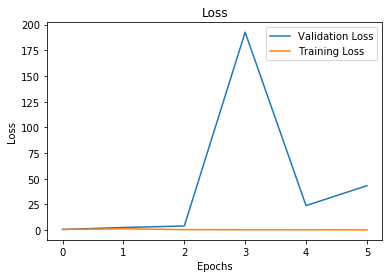

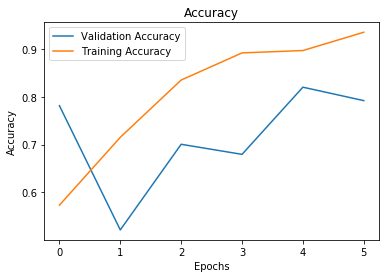

              precision    recall  f1-score   support

    Negative       0.34      0.43      0.38       115
    Positive       0.88      0.84      0.86       595

    accuracy                           0.77       710
   macro avg       0.61      0.63      0.62       710
weighted avg       0.79      0.77      0.78       710



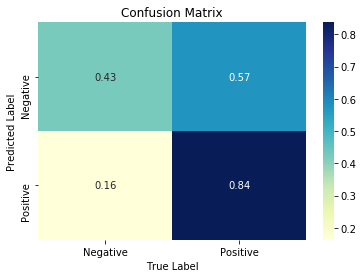

In [41]:
model2 = Sequential()
model2.add(Embedding(input_dim=len(word_index)+1, input_length=32, output_dim=100))
model2.add(LSTM(units=100, activation="relu"))
model2.add(Dense(1, activation="sigmoid"))
model2.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
results2 = model2.fit(X_train_padded, y_train, validation_data=(X_val_padded,y_val), callbacks=[earlystop],
                   epochs=30)
visualize_training_results(results2)
evaluate_model(model2, X_test_padded, y_test)

- Based on information from multiple runnings of these models, the tokenizer-created embedding layer produces better results. Therefore we will use it going forward.  
- This model had an increase in validation loss over time so we can try different optimizers.

Epoch 1/30
26/26 [==============================] - 2s 66ms/step - loss: 0.6931 - accuracy: 0.5074 - val_loss: 0.6937 - val_accuracy: 0.3486
Epoch 2/30
26/26 [==============================] - 1s 51ms/step - loss: 0.6931 - accuracy: 0.5074 - val_loss: 0.6937 - val_accuracy: 0.3627
Epoch 3/30
26/26 [==============================] - 1s 52ms/step - loss: 0.6930 - accuracy: 0.5210 - val_loss: 0.6949 - val_accuracy: 0.2570
Epoch 4/30
26/26 [==============================] - 1s 49ms/step - loss: 0.6930 - accuracy: 0.4988 - val_loss: 0.6943 - val_accuracy: 0.3028
Epoch 5/30
26/26 [==============================] - 1s 44ms/step - loss: 0.6929 - accuracy: 0.5223 - val_loss: 0.6932 - val_accuracy: 0.4718
Epoch 6/30
26/26 [==============================] - 1s 46ms/step - loss: 0.6928 - accuracy: 0.5569 - val_loss: 0.6932 - val_accuracy: 0.4683


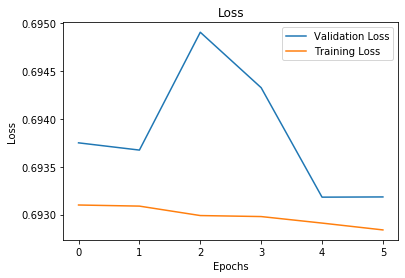

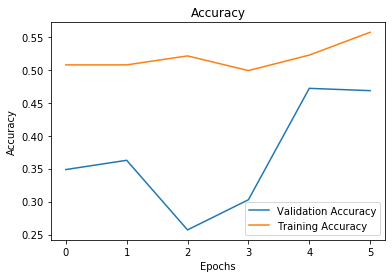

              precision    recall  f1-score   support

    Negative       0.18      0.80      0.30       115
    Positive       0.89      0.30      0.45       595

    accuracy                           0.38       710
   macro avg       0.53      0.55      0.37       710
weighted avg       0.77      0.38      0.42       710



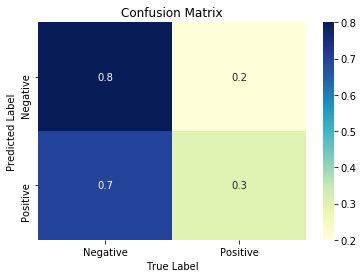

In [42]:
model3 = Sequential()
model3.add(Embedding(input_dim=len(word_index)+1, input_length=32, output_dim=100))
model3.add(LSTM(units=100, activation="relu"))
model3.add(Dense(1, activation="sigmoid"))
model3.compile(loss="binary_crossentropy", optimizer="sgd", metrics=["accuracy"])
results3 = model3.fit(X_train_padded, y_train, validation_data=(X_val_padded,y_val), callbacks=[earlystop],
                   epochs=30)
visualize_training_results(results3)
evaluate_model(model3, X_test_padded, y_test)

The sgd optimizer did not make improvements, so we can move on.

Epoch 1/30
26/26 [==============================] - 2s 65ms/step - loss: 0.6935 - accuracy: 0.4678 - val_loss: 0.6908 - val_accuracy: 0.7852
Epoch 2/30
26/26 [==============================] - 1s 49ms/step - loss: 0.6935 - accuracy: 0.4752 - val_loss: 0.6908 - val_accuracy: 0.7782
Epoch 3/30
26/26 [==============================] - 1s 48ms/step - loss: 0.6935 - accuracy: 0.4765 - val_loss: 0.6911 - val_accuracy: 0.7535
Epoch 4/30
26/26 [==============================] - 1s 46ms/step - loss: 0.6934 - accuracy: 0.4666 - val_loss: 0.6911 - val_accuracy: 0.7641
Epoch 5/30
26/26 [==============================] - 1s 51ms/step - loss: 0.6934 - accuracy: 0.4604 - val_loss: 0.6910 - val_accuracy: 0.7676
Epoch 6/30
26/26 [==============================] - 1s 48ms/step - loss: 0.6934 - accuracy: 0.4765 - val_loss: 0.6910 - val_accuracy: 0.7676


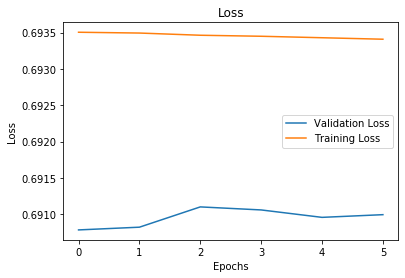

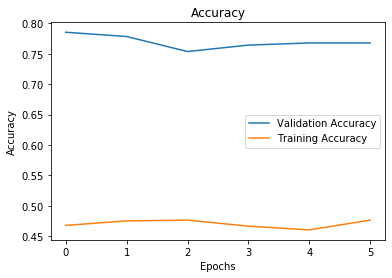

              precision    recall  f1-score   support

    Negative       0.07      0.03      0.04       115
    Positive       0.83      0.93      0.88       595

    accuracy                           0.78       710
   macro avg       0.45      0.48      0.46       710
weighted avg       0.71      0.78      0.74       710



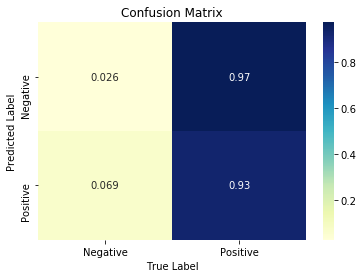

In [43]:
model4 = Sequential()
model4.add(Embedding(input_dim=len(word_index)+1, input_length=32, output_dim=100))
model4.add(LSTM(units=100, activation="relu"))
model4.add(Dense(1, activation="sigmoid"))
model4.compile(loss="binary_crossentropy", optimizer="Adagrad", metrics=["accuracy"])
results4 = model4.fit(X_train_padded, y_train, validation_data=(X_val_padded,y_val), callbacks=[earlystop],
                   epochs=30)
visualize_training_results(results4)
evaluate_model(model4, X_test_padded, y_test)

This model does not do as well as the base model so we can try and control overfitting vias regularizers and dropout on the original model.

Epoch 1/30
26/26 [==============================] - 4s 138ms/step - loss: 1.2671 - accuracy: 0.5186 - val_loss: 1.0573 - val_accuracy: 0.5986
Epoch 2/30
26/26 [==============================] - 3s 98ms/step - loss: 0.9386 - accuracy: 0.6200 - val_loss: 0.8377 - val_accuracy: 0.6127
Epoch 3/30
26/26 [==============================] - 3s 104ms/step - loss: 0.7665 - accuracy: 0.6881 - val_loss: 0.6049 - val_accuracy: 0.8345
Epoch 4/30
26/26 [==============================] - 3s 104ms/step - loss: 0.6078 - accuracy: 0.8144 - val_loss: 2.0421 - val_accuracy: 0.8169
Epoch 5/30
26/26 [==============================] - 3s 101ms/step - loss: 0.4138 - accuracy: 0.8738 - val_loss: 1.2841 - val_accuracy: 0.7993
Epoch 6/30
26/26 [==============================] - 3s 113ms/step - loss: 0.3389 - accuracy: 0.9035 - val_loss: 11.7514 - val_accuracy: 0.6303
Epoch 7/30
26/26 [==============================] - 3s 103ms/step - loss: 0.3209 - accuracy: 0.9455 - val_loss: 17.2824 - val_accuracy: 0.7817
Epoch

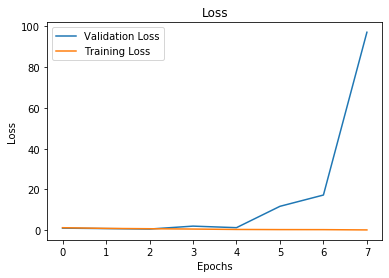

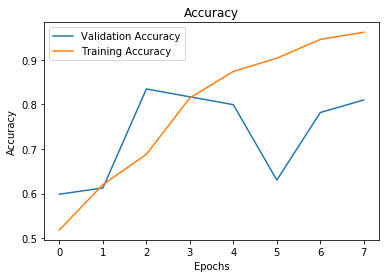

              precision    recall  f1-score   support

    Negative       0.57      0.23      0.33       115
    Positive       0.87      0.97      0.91       595

    accuracy                           0.85       710
   macro avg       0.72      0.60      0.62       710
weighted avg       0.82      0.85      0.82       710



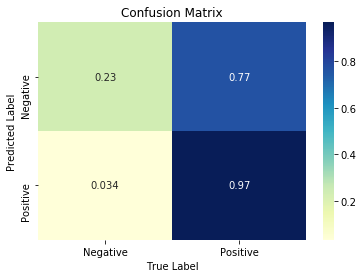

In [44]:
model5 = Sequential()
model5.add(Embedding(input_dim=len(word_index)+1, input_length=32, output_dim=100))
model5.add(LSTM(units=100, activation="relu", kernel_regularizer=regularizers.l2(0.005),
              recurrent_dropout=.15, dropout=.4))
model5.add(Dense(1, activation="sigmoid"))
model5.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
results5 = model5.fit(X_train_padded, y_train, validation_data=(X_val_padded,y_val), callbacks=[earlystop],
                   epochs=30)
visualize_training_results(results5)
evaluate_model(model5, X_test_padded, y_test)

Using l2 regularization did not help so we can try l1 regularization.

Epoch 1/30
26/26 [==============================] - 4s 153ms/step - loss: 9.4981 - accuracy: 0.5111 - val_loss: 7.1793 - val_accuracy: 0.5775
Epoch 2/30
26/26 [==============================] - 3s 102ms/step - loss: 5.5169 - accuracy: 0.5792 - val_loss: 3.8200 - val_accuracy: 0.8310
Epoch 3/30
26/26 [==============================] - 3s 108ms/step - loss: 2.7345 - accuracy: 0.6287 - val_loss: 1.7501 - val_accuracy: 0.1796
Epoch 4/30
26/26 [==============================] - 3s 106ms/step - loss: 1.1881 - accuracy: 0.5074 - val_loss: 0.8554 - val_accuracy: 0.1796
Epoch 5/30
26/26 [==============================] - 3s 106ms/step - loss: 0.7673 - accuracy: 0.5755 - val_loss: 0.7036 - val_accuracy: 0.8451
Epoch 6/30
26/26 [==============================] - 3s 102ms/step - loss: 1.8345 - accuracy: 0.5631 - val_loss: 1.2381 - val_accuracy: 0.8380
Epoch 7/30
26/26 [==============================] - 3s 105ms/step - loss: 1.1224 - accuracy: 0.7327 - val_loss: 1.3951 - val_accuracy: 0.6444
Epoch 

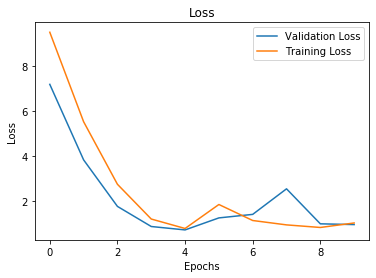

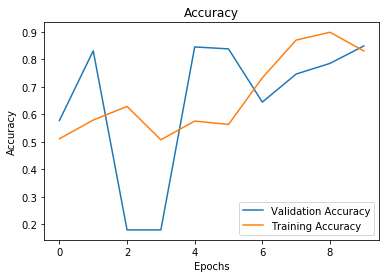

              precision    recall  f1-score   support

    Negative       0.53      0.25      0.34       115
    Positive       0.87      0.96      0.91       595

    accuracy                           0.84       710
   macro avg       0.70      0.60      0.63       710
weighted avg       0.81      0.84      0.82       710



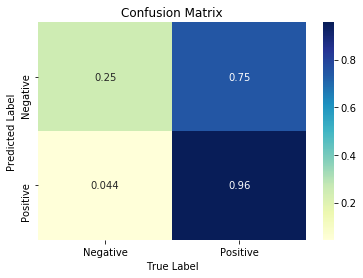

In [45]:
model6 = Sequential()
model6.add(Embedding(input_dim=len(word_index)+1, input_length=32, output_dim=100))
model6.add(LSTM(units=100, activation="relu", kernel_regularizer=regularizers.l1(0.005),
              recurrent_dropout=.15, dropout=.3))
model6.add(Dense(1, activation="sigmoid"))
model6.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
results6 = model6.fit(X_train_padded, y_train, validation_data=(X_val_padded,y_val), callbacks=[earlystop],
                   epochs=30)
visualize_training_results(results6)
evaluate_model(model6, X_test_padded, y_test)

- This model has very high loss (only exacerbated by further layers, as attempted but not shown) so we can move onto another approach. 
- Since we have tried different optimizers, we can also try different activation functions. 

Epoch 1/20
26/26 [==============================] - 2s 89ms/step - loss: 0.6929 - accuracy: 0.5050 - val_loss: 0.6850 - val_accuracy: 0.7923
Epoch 2/20
26/26 [==============================] - 1s 43ms/step - loss: 0.6698 - accuracy: 0.5953 - val_loss: 0.6882 - val_accuracy: 0.5070
Epoch 3/20
26/26 [==============================] - 1s 41ms/step - loss: 0.5252 - accuracy: 0.7748 - val_loss: 0.5026 - val_accuracy: 0.7430
Epoch 4/20
26/26 [==============================] - 1s 43ms/step - loss: 0.3358 - accuracy: 0.8923 - val_loss: 0.4278 - val_accuracy: 0.8028
Epoch 5/20
26/26 [==============================] - 1s 42ms/step - loss: 0.1880 - accuracy: 0.9381 - val_loss: 0.3736 - val_accuracy: 0.8556
Epoch 6/20
26/26 [==============================] - 1s 39ms/step - loss: 0.1025 - accuracy: 0.9678 - val_loss: 0.4903 - val_accuracy: 0.7641
Epoch 7/20
26/26 [==============================] - 1s 41ms/step - loss: 0.0735 - accuracy: 0.9851 - val_loss: 0.5135 - val_accuracy: 0.7782
Epoch 8/20
26

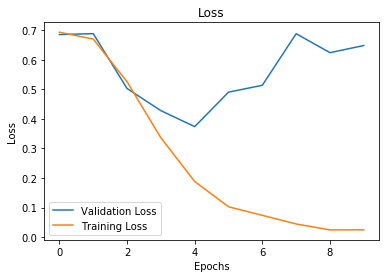

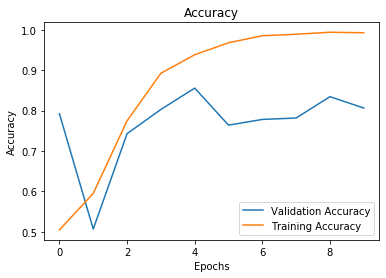

              precision    recall  f1-score   support

    Negative       0.44      0.56      0.49       115
    Positive       0.91      0.86      0.88       595

    accuracy                           0.81       710
   macro avg       0.67      0.71      0.69       710
weighted avg       0.83      0.81      0.82       710



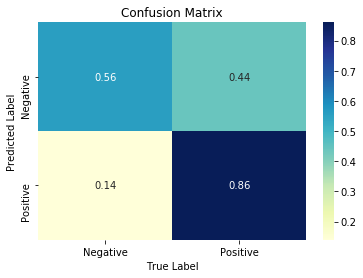

In [46]:
model7 = Sequential()
model7.add(Embedding(input_dim=len(word_index)+1, input_length=32, output_dim=10))
model7.add(LSTM(units=100, activation="tanh"))
model7.add(Dense(1, activation="sigmoid"))
model7.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
results7 = model7.fit(X_train_padded, y_train, validation_data=(X_val_padded,y_val), callbacks=[earlystop],
                   epochs=20)
visualize_training_results(results7)
evaluate_model(model7, X_test_padded, y_test)

Epoch 1/20
26/26 [==============================] - 2s 79ms/step - loss: 0.6936 - accuracy: 0.4839 - val_loss: 0.6904 - val_accuracy: 0.7394
Epoch 2/20
26/26 [==============================] - 1s 42ms/step - loss: 0.6866 - accuracy: 0.5631 - val_loss: 0.6637 - val_accuracy: 0.7993
Epoch 3/20
26/26 [==============================] - 1s 43ms/step - loss: 0.6174 - accuracy: 0.7512 - val_loss: 0.6640 - val_accuracy: 0.5845
Epoch 4/20
26/26 [==============================] - 1s 41ms/step - loss: 0.4456 - accuracy: 0.8156 - val_loss: 0.8055 - val_accuracy: 0.5387
Epoch 5/20
26/26 [==============================] - 1s 42ms/step - loss: 0.2653 - accuracy: 0.9022 - val_loss: 0.4183 - val_accuracy: 0.8204
Epoch 6/20
26/26 [==============================] - 1s 41ms/step - loss: 0.1374 - accuracy: 0.9455 - val_loss: 0.4504 - val_accuracy: 0.7923
Epoch 7/20
26/26 [==============================] - 1s 41ms/step - loss: 0.1073 - accuracy: 0.9678 - val_loss: 0.7129 - val_accuracy: 0.6690
Epoch 8/20
26

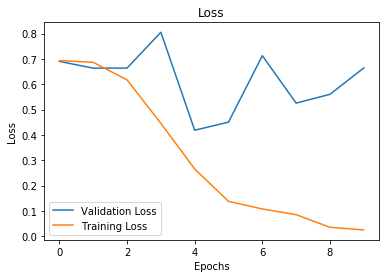

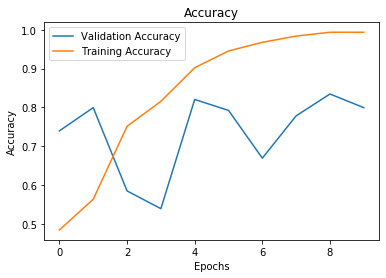

              precision    recall  f1-score   support

    Negative       0.41      0.63      0.50       115
    Positive       0.92      0.82      0.87       595

    accuracy                           0.79       710
   macro avg       0.66      0.73      0.68       710
weighted avg       0.84      0.79      0.81       710



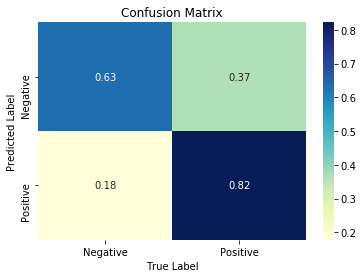

In [47]:
model8 = Sequential()
model8.add(Embedding(input_dim=len(word_index)+1, input_length=32, output_dim=10))
model8.add(LSTM(units=100, activation="tanh"))
model8.add(Dense(1, activation="sigmoid"))
model8.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
results8 = model8.fit(X_train_padded, y_train, validation_data=(X_val_padded,y_val), callbacks=[earlystop],
                   epochs=20)
visualize_training_results(results8)
evaluate_model(model8, X_test_padded, y_test)

This model seems worthy of further exploration to address overfitting. We can start with l2 regularization.

Epoch 1/30
26/26 [==============================] - 4s 137ms/step - loss: 1.2682 - accuracy: 0.5396 - val_loss: 1.0455 - val_accuracy: 0.7535
Epoch 2/30
26/26 [==============================] - 3s 99ms/step - loss: 0.8987 - accuracy: 0.6572 - val_loss: 0.9102 - val_accuracy: 0.4401
Epoch 3/30
26/26 [==============================] - 3s 107ms/step - loss: 0.5681 - accuracy: 0.8168 - val_loss: 0.6813 - val_accuracy: 0.6901
Epoch 4/30
26/26 [==============================] - 3s 99ms/step - loss: 0.3334 - accuracy: 0.9121 - val_loss: 1.7724 - val_accuracy: 0.3908
Epoch 5/30
26/26 [==============================] - 3s 97ms/step - loss: 0.3011 - accuracy: 0.9010 - val_loss: 0.6997 - val_accuracy: 0.6725
Epoch 6/30
26/26 [==============================] - 3s 100ms/step - loss: 0.1651 - accuracy: 0.9715 - val_loss: 0.7357 - val_accuracy: 0.7148
Epoch 7/30
26/26 [==============================] - 3s 106ms/step - loss: 0.1146 - accuracy: 0.9777 - val_loss: 0.5390 - val_accuracy: 0.7958
Epoch 8/3

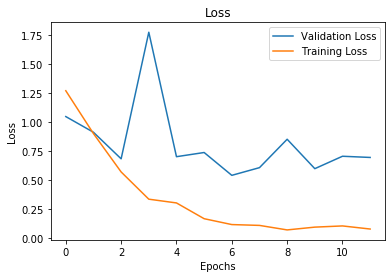

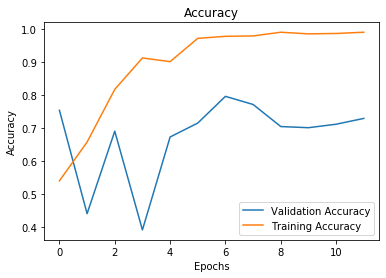

              precision    recall  f1-score   support

    Negative       0.43      0.67      0.52       115
    Positive       0.93      0.83      0.87       595

    accuracy                           0.80       710
   macro avg       0.68      0.75      0.70       710
weighted avg       0.85      0.80      0.82       710



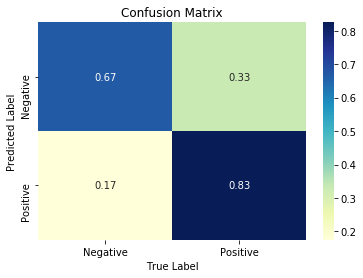

In [48]:
model9 = Sequential()
model9.add(Embedding(input_dim=len(word_index)+1, input_length=32, output_dim=100))
model9.add(LSTM(units=100, activation="tanh", kernel_regularizer=regularizers.l2(0.005),
              recurrent_dropout=.15, dropout=.4))
model9.add(Dense(1, activation="sigmoid"))
model9.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
results9 = model9.fit(X_train_padded, y_train, validation_data=(X_val_padded,y_val), callbacks=[earlystop],
                   epochs=30)
visualize_training_results(results9)
evaluate_model(model9, X_test_padded, y_test)

This model is an improvement but we can also try l1 regularization. 

Epoch 1/30
26/26 [==============================] - 3s 131ms/step - loss: 9.3825 - accuracy: 0.5074 - val_loss: 7.0708 - val_accuracy: 0.7711
Epoch 2/30
26/26 [==============================] - 3s 112ms/step - loss: 5.4147 - accuracy: 0.5978 - val_loss: 3.9675 - val_accuracy: 0.1796
Epoch 3/30
26/26 [==============================] - 3s 111ms/step - loss: 2.6646 - accuracy: 0.7290 - val_loss: 1.7503 - val_accuracy: 0.5845
Epoch 4/30
26/26 [==============================] - 3s 120ms/step - loss: 1.1905 - accuracy: 0.7822 - val_loss: 0.9993 - val_accuracy: 0.5387
Epoch 5/30
26/26 [==============================] - 3s 113ms/step - loss: 0.6667 - accuracy: 0.8354 - val_loss: 0.7333 - val_accuracy: 0.7007
Epoch 6/30
26/26 [==============================] - 3s 107ms/step - loss: 0.4616 - accuracy: 0.8973 - val_loss: 0.6409 - val_accuracy: 0.7711
Epoch 7/30
26/26 [==============================] - 3s 102ms/step - loss: 0.3674 - accuracy: 0.9381 - val_loss: 0.7427 - val_accuracy: 0.6655
Epoch 

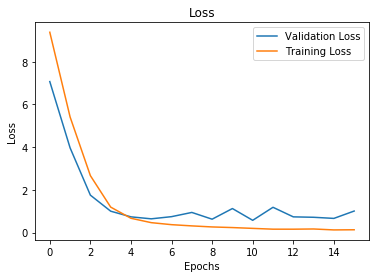

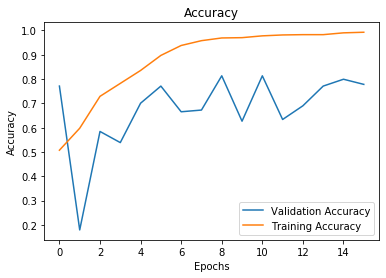

              precision    recall  f1-score   support

    Negative       0.40      0.69      0.51       115
    Positive       0.93      0.80      0.86       595

    accuracy                           0.78       710
   macro avg       0.67      0.74      0.68       710
weighted avg       0.84      0.78      0.80       710



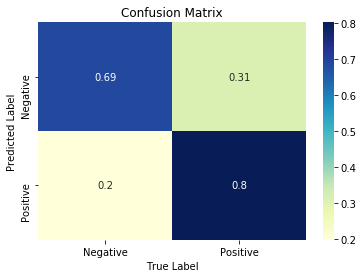

In [49]:
model10 = Sequential()
model10.add(Embedding(input_dim=len(word_index)+1, input_length=32, output_dim=100))
model10.add(LSTM(units=100, activation="tanh", kernel_regularizer=regularizers.l1(0.005),
              recurrent_dropout=.15, dropout=.4))
model10.add(Dense(1, activation="sigmoid"))
model10.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
results10 = model10.fit(X_train_padded, y_train, validation_data=(X_val_padded,y_val), callbacks=[earlystop],
                   epochs=30)
visualize_training_results(results10)
evaluate_model(model10, X_test_padded, y_test)

The l1 regularization function does not seem to result in an improved model. 

# Best Neural Network Model

Although none of the models are performing as well as we might hope, the second-to-last model is our most promising so we can save it for future use. 

In [50]:
#from https://machinelearningmastery.com/save-load-keras-deep-learning-models/, save the model and weights
# model_json = model9.to_json()
# with open("best_model.json", "w") as json_file:
#     json_file.write(model_json)
# model2.save_weights("best_model.h5")

Epoch 1/30
26/26 [==============================] - 2s 92ms/step - loss: 1.1978 - accuracy: 0.7475 - val_loss: 1.0203 - val_accuracy: 0.7254
Epoch 2/30
26/26 [==============================] - 2s 72ms/step - loss: 0.7094 - accuracy: 0.8515 - val_loss: 0.9729 - val_accuracy: 0.6620
Epoch 3/30
26/26 [==============================] - 2s 73ms/step - loss: 0.4576 - accuracy: 0.8998 - val_loss: 0.6140 - val_accuracy: 0.8063
Epoch 4/30
26/26 [==============================] - 2s 69ms/step - loss: 0.3232 - accuracy: 0.9431 - val_loss: 0.6285 - val_accuracy: 0.7852
Epoch 5/30
26/26 [==============================] - 2s 81ms/step - loss: 0.2208 - accuracy: 0.9715 - val_loss: 0.9287 - val_accuracy: 0.6901
Epoch 6/30
26/26 [==============================] - 2s 79ms/step - loss: 0.1618 - accuracy: 0.9889 - val_loss: 0.8870 - val_accuracy: 0.7430
Epoch 7/30
26/26 [==============================] - 2s 79ms/step - loss: 0.1451 - accuracy: 0.9876 - val_loss: 0.6474 - val_accuracy: 0.7887
Epoch 8/30
26

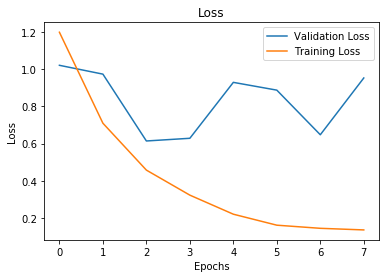

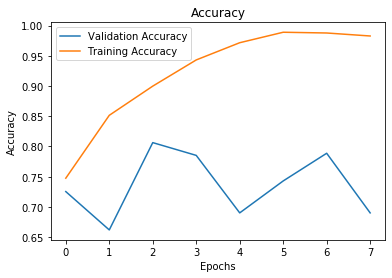

              precision    recall  f1-score   support

    Negative       0.40      0.70      0.50       115
    Positive       0.93      0.79      0.86       595

    accuracy                           0.78       710
   macro avg       0.66      0.75      0.68       710
weighted avg       0.84      0.78      0.80       710



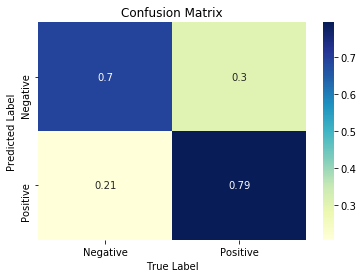

In [53]:
#from https://machinelearningmastery.com/save-load-keras-deep-learning-models/, load the model and weights
json_file = open("best_model.json", "r")
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("best_model.h5")
loaded_model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])
results = loaded_model.fit(X_train_padded, y_train, validation_data=(X_val_padded,y_val), callbacks=[earlystop],
                   epochs=30)
visualize_training_results(results)
evaluate_model(loaded_model, X_test_padded, y_test)

Overall the model performs its classification task fairly well. While the validation accuracy is very unstable and the model is overfit, it is more accurate than random chance.  

In [52]:
loaded_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 32, 100)           279100    
_________________________________________________________________
lstm_8 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 101       
Total params: 359,601
Trainable params: 359,601
Non-trainable params: 0
_________________________________________________________________


# Best Overall Model

- Our best logistic regression model performs equally or better than our best neural network model on all metrics and is 82% accurate as opposed to 75% accurate.
- In addition, our logistic regression model is more stable than our neural network model. 
- Lastly our logistic regression model is faster to run and requires fewer resources than out best neural network model.
- While there is room for improvement, the logistic regression model is more cost-effective and accurate.

# Conclusion

&nbsp; &nbsp; &nbsp; Our best model is a logistic regression classifier, which is 82% accurate. When comparing simpler models to neural network models, we found that the simpler models were more consistent, accurate, and easier to implement. Our model performs better than chance at identifying whether a tweet was positive or negative, but there is potential for improvement. As one would expect, more positive words are a good indication that a tweet is speaking positively about the product and vice versa. Action words, i.e. will, are more common in negative tweets, perhaps indicating that people are tweeting about their intention to stop using a product. From our examination of the top 25 words for each emotion, it appears that people tended to tweet more positively about the excitement of new products. 

## Recommendations

- More complex is not always better.
- Using a logistic regression model to classify tweets as positive or negative can produce good results.
- Because the model only correctly classifies negative tweets 75% of the time and positive tweets 83% of the time, it is important to check the model against human verification.
- Tweets using this model should have urls, hashtags, and usernames removed.

## Limitations

- A good portion of this data came from tweets relating to SXSW, a singular event that may not paint a full picture of positive and negative tweets. This was most apparent in our bigrams. 
- In addition, because of the class imbalance, these models were trained on fairly small datasets so more data would be useful. 
- Lastly, in this case we did not use the neutral tweet data and it should be examined in the future. 